In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
class TextPreprocessor:
    def __init__(self, max_vocab_size=10000, max_seq_length=500):
        self.max_vocab_size = max_vocab_size
        self.max_seq_length = max_seq_length
        self.word2idx = {}
        self.idx2word = {}
        self.stop_words = set(stopwords.words('english'))
        
    def clean_text(self, text):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = ' '.join(text.split())
        return text
    
    def tokenize(self, text):
        tokens = word_tokenize(text)
        # Remove stopwords
        tokens = [token for token in tokens if token not in self.stop_words]
        return tokens
    
    def build_vocabulary(self, texts):
        # Flatten all tokens
        all_tokens = []
        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize(cleaned_text)
            all_tokens.extend(tokens)
        
        # Get most common words
        word_counts = Counter(all_tokens)
        most_common = word_counts.most_common(self.max_vocab_size - 2)  # -2 for PAD and UNK
        
        # Create vocabulary
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        for word, _ in most_common:
            self.word2idx[word] = len(self.word2idx)
        
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
    
    def text_to_sequence(self, text):
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize(cleaned_text)
        
        # Convert tokens to indices
        sequence = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        
        # Pad or truncate sequence
        if len(sequence) < self.max_seq_length:
            sequence.extend([self.word2idx['<PAD>']] * (self.max_seq_length - len(sequence)))
        else:
            sequence = sequence[:self.max_seq_length]
        
        return sequence

In [4]:
class ResumeDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        sequence = self.preprocessor.text_to_sequence(text)
        return torch.tensor(sequence), torch.tensor(label, dtype=torch.long)  # Convert label to Long type 

In [5]:

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, 
                         bidirectional=True, batch_first=True, dropout=dropout)
                        #  batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text = [batch size, seq len]
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, seq len, embedding dim]
        
        output, hidden = self.gru(embedded)
        # output = [batch size, seq len, hidden dim * 2]
        # hidden = [n layers * 2, batch size, hidden dim]
        
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden = [batch size, hidden dim * 2]
        
        return self.fc(self.dropout(hidden))

In [6]:

class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [7]:

def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=30):
    best_val_loss = float('inf')
    early_stopping = EarlyStopping(patience=3)
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch: {epoch+1}')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return train_losses, val_losses

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    return all_preds, all_targets

In [8]:
# Load data
df = pd.read_csv('Resume Dataset/new_pdf_to_resume.csv')

# Initialize preprocessor
preprocessor = TextPreprocessor()
preprocessor.build_vocabulary(df['resume'].values)


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\ZK/nltk_data'
    - 'c:\\Users\\ZK\\AppData\\Local\\Programs\\Python\\Python310\\nltk_data'
    - 'c:\\Users\\ZK\\AppData\\Local\\Programs\\Python\\Python310\\share\\nltk_data'
    - 'c:\\Users\\ZK\\AppData\\Local\\Programs\\Python\\Python310\\lib\\nltk_data'
    - 'C:\\Users\\ZK\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['occupation'])

X = df['resume'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:
# Create datasets
train_dataset = ResumeDataset(X_train, y_train, preprocessor)
val_dataset = ResumeDataset(X_val, y_val, preprocessor)
test_dataset = ResumeDataset(X_test, y_test, preprocessor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRUClassifier(
    vocab_size=len(preprocessor.word2idx),
    embedding_dim=300,
    # embedding_dim=300,
    hidden_dim=128,
    # hidden_dim=256,
    output_dim=len(label_encoder.classes_),
    n_layers=3,
    dropout=0.2
).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train model
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, device
)

# targes_test, predictions_test = evaluate_model(model, val_loader, device)
# print("\nClassification Report:")
# print(classification_report(targes_test, predictions_test, target_names=label_encoder.classes_))

# Evaluate model
predictions, targets = evaluate_model(model, test_loader, device)
# Calculate and print accuracy
accuracy = np.mean(np.array(predictions) == np.array(targets))
print(f"\nAccuracy: {accuracy:.4f}")


Epoch: 1
Training Loss: 2.3914
Validation Loss: 1.4038
Epoch: 2
Training Loss: 1.1420
Validation Loss: 1.0803
Epoch: 3
Training Loss: 0.7715
Validation Loss: 1.1010
Epoch: 4
Training Loss: 0.5223
Validation Loss: 1.1244
Epoch: 5
Training Loss: 0.3055
Validation Loss: 1.1862
Early stopping triggered

Accuracy: 0.7051


In [ ]:
# Print classification report
print("\nClassification Report:")
print(classification_report(targets, predictions, target_names=label_encoder.classes_))



Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.94      1.00      0.97        17
              ADVOCATE       0.50      0.76      0.60        17
           AGRICULTURE       0.33      0.10      0.15        10
               APPAREL       0.22      0.14      0.17        14
                  ARTS       0.24      0.38      0.29        16
            AUTOMOBILE       0.00      0.00      0.00         5
              AVIATION       0.40      0.56      0.47        18
               BANKING       0.44      0.39      0.41        18
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.86      1.00      0.92        18
                  CHEF       0.92      0.65      0.76        17
          CONSTRUCTION       1.00      0.82      0.90        17
            CONSULTANT       0.90      1.00      0.95        18
              DESIGNER       0.89      1.00      0.94        16
         DIGITA

c:\Users\ZK\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ZK\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ZK\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

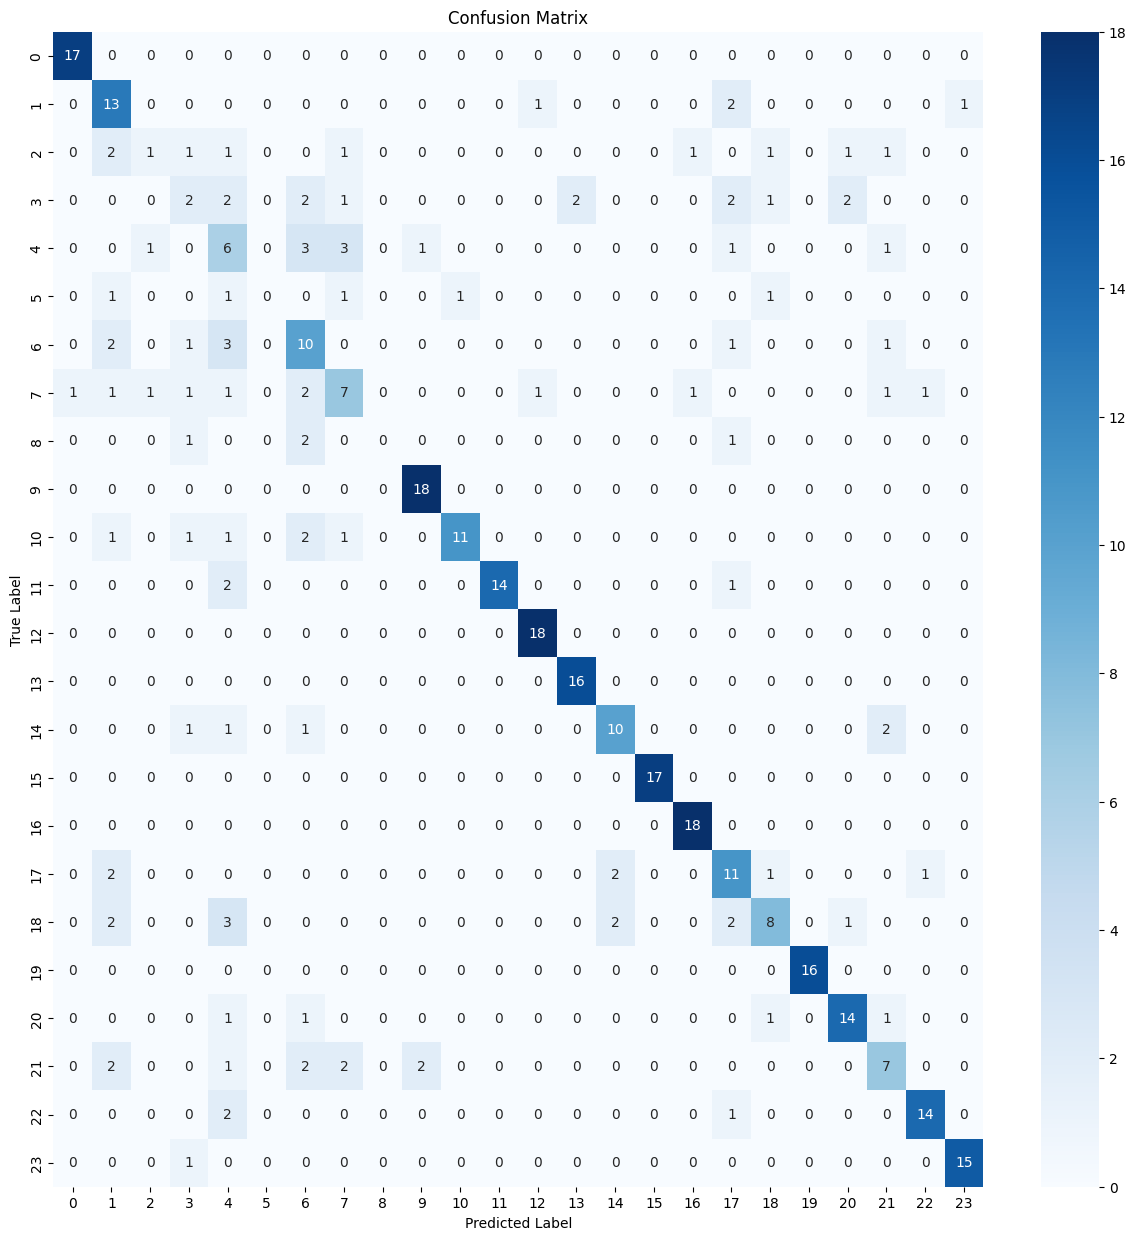

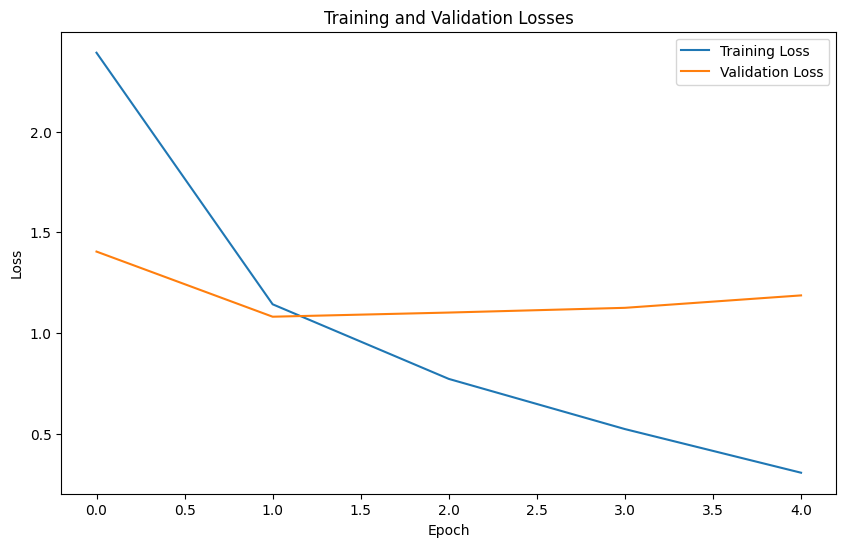

In [ ]:

# Plot confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def reset_model_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        elif isinstance(layer, nn.Sequential):
            for l in layer:
                if hasattr(l, 'reset_parameters'):
                    l.reset_parameters()

# Usage:
reset_model_weights(model)